# Classification of speech data samples into 'Cold' and 'Not Cold' classes using a baseline (Support vector machines) and deep learning (Feedforward Neural network and Convolutional neural network)

Class imbalance techniques like random undersampling, random oversampling and inclusion of class weights are used as the dataset is unbalanced.

The data is already divided into train and development datasets. We will train the model on train data and evaluate on development data

In [1]:
import numpy as np
import pandas as pd

In [80]:
import matplotlib.pyplot as plt

Read the data (train and development data)

In [2]:
# Read the data into pandas dataframe
train_data = pd.read_csv("train.csv",sep=';')

Drop the frameTime

In [4]:
train_data = train_data.drop(['name', 'frameTime'], axis=1)

In [5]:
devel_data = pd.read_csv("eGeMAPS/eGeMAPS/devel.csv",sep=';')
devel_data = devel_data.drop(['name', 'frameTime'], axis=1)

Convert dataframes to numpy array

In [7]:
x_train = train_data.values
x_devel = devel_data.values

Read the labels (train and development)

In [9]:
# Read in data as CSV
train_labels = pd.read_csv("Labels/Labels/train.csv")

devel_labels = pd.read_csv("Labels/Labels/devel.csv")


In [10]:
train_labels.head()

,file_name,Cold (upper respiratory tract infection)
0,train_0001.wav,C
1,train_0002.wav,NC
2,train_0003.wav,NC
3,train_0004.wav,C
4,train_0005.wav,NC


In [11]:
devel_labels.head()

,file_name,Cold
0,devel_0001.wav,NC
1,devel_0002.wav,NC
2,devel_0003.wav,NC
3,devel_0004.wav,NC
4,devel_0005.wav,NC


In [12]:
train_labels = train_labels.drop(['file_name'], axis=1)
devel_labels = devel_labels.drop(['file_name'], axis=1)

In [13]:
train_labels.head()

,Cold (upper respiratory tract infection)
0,C
1,NC
2,NC
3,C
4,NC


In [14]:
devel_labels.head()

,Cold
0,NC
1,NC
2,NC
3,NC
4,NC


Convert the labels 'NC' and 'C' to 0 and 1 respectively. Thus 0 will represent 'NC' (Not Cold) class and 1 will represent 'C'
(Cold) class. For this .map() function is used, for which first labels are converted to pandas series using function .squeeze()

In [16]:
y_train = train_labels['Cold (upper respiratory tract infection)'].squeeze()

In [17]:
y_train = y_train.map({'NC': 0, 'C': 1})

In [18]:
y_train.head()

0    1
1    0
2    0
3    1
4    0
Name: Cold (upper respiratory tract infection), dtype: int64

In [19]:
y_devel = devel_labels['Cold'].squeeze()

In [20]:
y_devel = y_devel.map({'NC': 0, 'C': 1})

In [21]:
y_devel.head()

0    0
1    0
2    0
3    0
4    0
Name: Cold, dtype: int64

Scale the data using minmax scaler

In [23]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(x_train)
x_devel_scaled = min_max_scaler.transform(x_devel)

# Support Vactor Machines

Classifier used : Support Vector Machines, 
Training on train data and model evaluation on development data

In [24]:
from sklearn.svm import SVC

Untuned model

In [25]:
model = SVC()

In [26]:
untuned_model = model.fit(x_train_scaled, y_train)

In [27]:
predict_untuned = model.predict(x_devel_scaled)

In [66]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
import seaborn as sns

In [29]:
cm_untuned_model = confusion_matrix(y_devel, predict_untuned)
print(cm_untuned_model)

[[8581    4]
 [ 989   22]]


<AxesSubplot:>

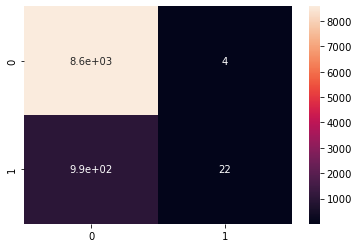

In [365]:
sns.heatmap(cm_untuned_model, annot=True)

In [30]:
classification_report_untuned_model = classification_report(y_devel, predict_untuned)
print(classification_report_untuned_model)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      8585
           1       0.85      0.02      0.04      1011

    accuracy                           0.90      9596
   macro avg       0.87      0.51      0.49      9596
weighted avg       0.89      0.90      0.85      9596



Tuned SVM without any data imbalance techniques

In [32]:
params = {'C': [0.01, 0.1, 1, 10],
              'gamma': [0.01, 0.1, 1, 10],
              'kernel': ['linear','poly','sigmoid','rbf']}

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

Grid search CV used with repeated startified K fold as this is an unbalanced data

In [34]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

F1_macro is the chosen metric here, F1 score gives an idea of both the precision and recall and is most commonly is used for imbalanced data. F1 macro calculates the scores per class, is therefore better for imbalanced class.

In [35]:
grid = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring='f1_macro')

In [36]:
grid_result_tuned = grid.fit(x_train_scaled, y_train)
best_score_tuned = grid_result_tuned.best_score_
best_params_tuned = grid_result_tuned.best_params_
best_model_tuned = grid_result_tuned.best_estimator_

print(best_score_tuned)
print(best_params_tuned)

# save the model
import pickle
filename = 'AI_model_tuned.sav'
pickle.dump(best_model_tuned, open(filename, 'wb'))

0.9137092206236925
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [44]:
# testing on development data
predict_tuned = best_model_tuned.predict(x_devel_scaled)

In [45]:
cm_tuned_model = confusion_matrix(y_devel, predict_tuned)
print(cm_tuned_model)

[[8373  212]
 [ 893  118]]


<AxesSubplot:>

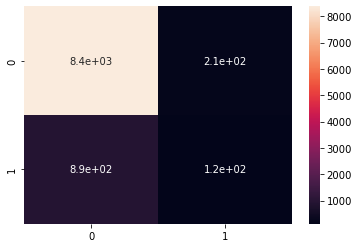

In [364]:
sns.heatmap(cm_tuned_model, annot=True)

In [46]:
classification_report_tuned_model = classification_report(y_devel, predict_tuned)
print(classification_report_tuned_model)

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      8585
           1       0.36      0.12      0.18      1011

    accuracy                           0.88      9596
   macro avg       0.63      0.55      0.56      9596
weighted avg       0.85      0.88      0.86      9596



Using data imbalance techniques

Random Undersampling

In [37]:
from imblearn.under_sampling import RandomUnderSampler

Undersample the majority class, in this case 'NC' (not cold)

In [38]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [39]:
from collections import Counter

In [40]:
Counter(y_train)

Counter({1: 970, 0: 8535})

In [41]:
# fit and transorm
x_under, y_under = undersample.fit_resample(x_train_scaled, y_train)

In [42]:
Counter(y_under)

Counter({0: 970, 1: 970})

In [43]:
grid_result_tuned_under = grid.fit(x_under, y_under)
best_score_tuned_under = grid_result_tuned_under.best_score_
best_params_tuned_under = grid_result_tuned_under.best_params_
best_model_tuned_under = grid_result_tuned_under.best_estimator_

print(best_score_tuned_under)
print(best_params_tuned_under)

# save the model
import pickle
filename = 'AI_model_tuned_under.sav'
pickle.dump(best_model_tuned_under, open(filename, 'wb'))

0.9157987561868312
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [47]:
predict_tuned_under = best_model_tuned_under.predict(x_devel_scaled)

In [48]:
cm_tuned_under_model = confusion_matrix(y_devel, predict_tuned_under)
print(cm_tuned_under_model)

[[7504 1081]
 [ 685  326]]


<AxesSubplot:>

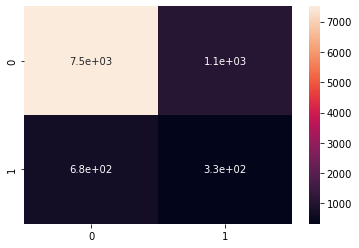

In [363]:
sns.heatmap(cm_tuned_under_model, annot=True)

In [49]:
classification_report_tuned_under_model = classification_report(y_devel, predict_tuned_under)
print(classification_report_tuned_under_model)

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      8585
           1       0.23      0.32      0.27      1011

    accuracy                           0.82      9596
   macro avg       0.57      0.60      0.58      9596
weighted avg       0.84      0.82      0.83      9596



Random Oversampling

In [50]:
from imblearn.over_sampling import RandomOverSampler

In [51]:
Counter(y_train)

Counter({1: 970, 0: 8535})

Oversample the minority class, in this case 'C' (cold)

In [52]:
oversample = RandomOverSampler(sampling_strategy='minority')

In [53]:
x_over, y_over = oversample.fit_resample(x_train_scaled, y_train)

In [54]:
Counter(y_over)

Counter({1: 8535, 0: 8535})

In [55]:
grid_result_tuned_over = grid.fit(x_over, y_over)
best_score_tuned_over = grid_result_tuned_over.best_score_
best_params_tuned_over = grid_result_tuned_over.best_params_
best_model_tuned_over = grid_result_tuned_over.best_estimator_

print(best_score_tuned_over)
print(best_params_tuned_over)

# save the model
import pickle
filename = 'AI_model_tuned_over.sav'
pickle.dump(best_model_tuned_over, open(filename, 'wb'))

0.9995313414041752
{'C': 10, 'gamma': 10, 'kernel': 'rbf'}


In [56]:
predict_tuned_over = best_model_tuned_over.predict(x_devel_scaled)

In [57]:
cm_tuned_over_model = confusion_matrix(y_devel, predict_tuned_over)
print(cm_tuned_over_model)

[[8570   15]
 [1005    6]]


<AxesSubplot:>

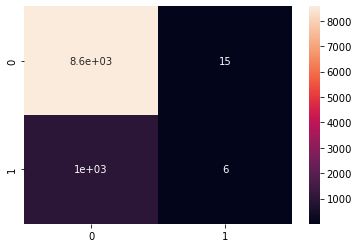

In [362]:
sns.heatmap(cm_tuned_over_model, annot=True)

In [58]:
classification_report_tuned_over_model = classification_report(y_devel, predict_tuned_over)
print(classification_report_tuned_over_model)

              precision    recall  f1-score   support

           0       0.90      1.00      0.94      8585
           1       0.29      0.01      0.01      1011

    accuracy                           0.89      9596
   macro avg       0.59      0.50      0.48      9596
weighted avg       0.83      0.89      0.85      9596



Inclusion of class weights = 'balanced'. This adjusts the weights inversely proportional to class frequencies in the input data

In [60]:
model_class_weights = SVC(class_weight = 'balanced')

In [61]:
grid_class_weights = GridSearchCV(estimator=model_class_weights, param_grid=params, cv=cv, scoring='f1_macro')

In [62]:
grid_result_class_weights = grid_class_weights.fit(x_train_scaled, y_train)
best_score_class_weights = grid_result_class_weights.best_score_
best_params_class_weights = grid_result_class_weights.best_params_
best_model_class_weights = grid_result_class_weights.best_estimator_

print(best_score_class_weights)
print(best_params_class_weights)

# save the model
import pickle
filename = 'AI_model_class_weights.sav'
pickle.dump(best_model_class_weights, open(filename, 'wb'))

0.9153130814232723
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [63]:
predict_class_weights = best_model_class_weights.predict(x_devel_scaled)

In [67]:
cm_class_weights = confusion_matrix(y_devel, predict_class_weights)
print(cm_class_weights)

[[8194  391]
 [ 844  167]]


In [65]:
classification_report_class_weights_model = classification_report(y_devel, predict_class_weights)
print(classification_report_class_weights_model)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      8585
           1       0.30      0.17      0.21      1011

    accuracy                           0.87      9596
   macro avg       0.60      0.56      0.57      9596
weighted avg       0.84      0.87      0.85      9596



<AxesSubplot:>

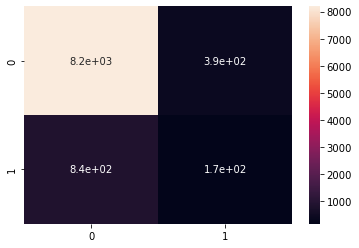

In [68]:
sns.heatmap(cm_class_weights, annot=True)

# Neural Network Classification

In [369]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import BatchNormalization
from keras.layers import Dropout
from sklearn.metrics import accuracy_score

Function to plot the training and validation accuracy values  and loss values

In [71]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

Convert the training labels to one-hot vecotrs

In [73]:
y_train_vec = to_categorical(y_train, 2)
y_devel_vec = to_categorical(y_devel, 2)

Scale the data using Standard scaler

In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_ss_scaled = scaler.fit_transform(x_train)
x_devel_ss_scaled = scaler.transform(x_devel)

Check the number of features

In [78]:
x_train_ss_scaled.shape[1]

88

In [98]:
n_features = x_train_ss_scaled.shape[1]

For the following deep learning models, training is done on train data and model evaluation on development data

Feedforward (dense) neural networks

Feedforward Neural Network Model 1: Three layers, with 'relu' activation and final activation is sigmoid, optimizer = adam, loss function = binary crossentropy

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 88)                7832      
                                                                 
 dense_13 (Dense)            (None, 44)                3916      
                                                                 
 dense_14 (Dense)            (None, 22)                990       
                                                                 
 dense_15 (Dense)            (None, 2)                 46        
                                                                 
Total params: 12,784
Trainable params: 12,784
Non-trainable params: 0
_________________________________________________________________
None


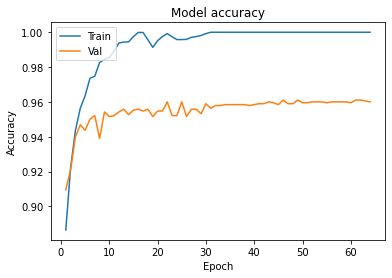

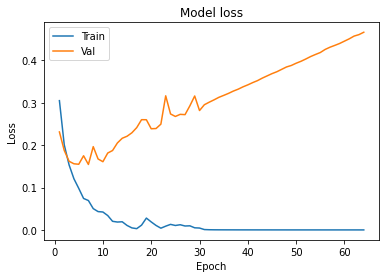

In [100]:
def FF_1():
    model = Sequential()
    model.add(Dense(88, input_dim=n_features, activation='relu'))
    model.add(Dense(44, activation='relu'))
    model.add(Dense(22, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    print(model.summary())
    return model

model_FF_1 = FF_1()

model_FF_1.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS = 64
BATCH_SIZE = 32

history = model_FF_1.fit(
    x_train_ss_scaled, y_train_vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=0
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.876


<AxesSubplot:>

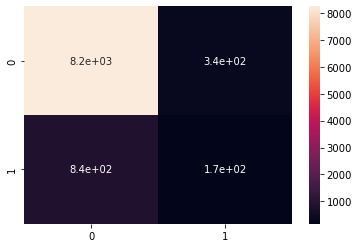

In [125]:
y_pred_vec_model_FF_1 = model_FF_1.predict(x_devel_ss_scaled)

# Convert output back to a single column array
y_pred_model_FF_1 = np.argmax(y_pred_vec_model_FF_1, axis=1)


acc_model_FF_1 = accuracy_score(y_devel, y_pred_model_FF_1)

print( "Classification accuracy is:  " + str(round(acc_model_FF_1,3)))

cm_model_FF_1 = confusion_matrix(y_devel, y_pred_model_FF_1)
sns.heatmap(cm_model_FF_1, annot=True)

In [123]:
classification_report_model_FF_1 = classification_report(y_devel, y_pred_model_FF_1)
print(classification_report_model_FF_1)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      8585
           1       0.33      0.18      0.23      1011

    accuracy                           0.88      9596
   macro avg       0.62      0.57      0.58      9596
weighted avg       0.85      0.88      0.86      9596



Feedforward Neural Network Model 2

Feedforward neural network model 2 with dropout (regularization), epochs = 128 and batch size = 64

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                5696      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_21 (Dense)            (None, 2)                 34        
                                                                 
Total params: 8,338
Trainable params: 8,338
Non-traina

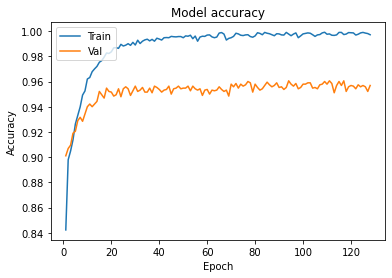

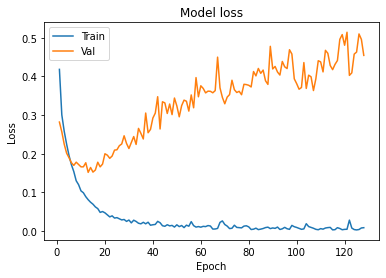

In [128]:
# 2nd model
def FF_2():
    model = Sequential()
    model.add(Dense(64, input_dim=n_features, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='sigmoid'))
    print(model.summary())
    return model

model_FF_2 = FF_2()

model_FF_2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS = 128
BATCH_SIZE = 64

history = model_FF_2.fit(
    x_train_ss_scaled, y_train_vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=0
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.868


<AxesSubplot:>

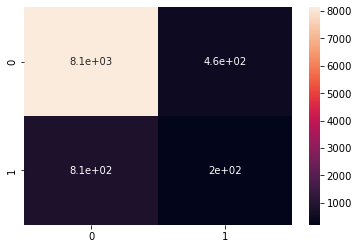

In [129]:
y_pred_vec_model_FF_2 = model_FF_2.predict(x_devel_ss_scaled)

y_pred_model_FF_2 = np.argmax(y_pred_vec_model_FF_2, axis=1)


acc_model_FF_2 = accuracy_score(y_devel, y_pred_model_FF_2)

print( "Classification accuracy is:  " + str(round(acc_model_FF_2,3)))

cm_model_FF_2 = confusion_matrix(y_devel, y_pred_model_FF_2)
sns.heatmap(cm_model_FF_2, annot=True)

In [130]:
classification_report_model_FF_2 = classification_report(y_devel, y_pred_model_FF_2)
print(classification_report_model_FF_2)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      8585
           1       0.31      0.20      0.24      1011

    accuracy                           0.87      9596
   macro avg       0.61      0.57      0.59      9596
weighted avg       0.85      0.87      0.86      9596



Feedforward Neural Network Model 3

Feedforward neural network with optimizer changed to rmsprop, epochs = 500, batch size = 128

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 64)                5696      
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_33 (Dense)            (None, 2)                 66        
                                                                 
Total params: 7,842
Trainable params: 7,842
Non-trainable params: 0
_________________________________________________________________
None


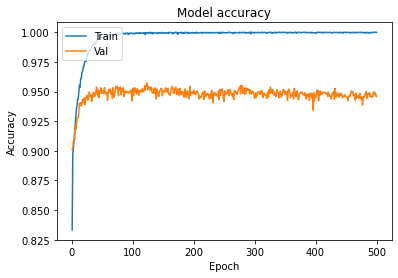

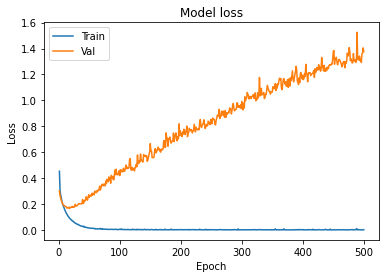

In [134]:
# model 3

def FF_3():
    model = Sequential()
    model.add(Dense(64, input_dim=n_features, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='sigmoid'))
    print(model.summary())
    return model

model_FF_3 = FF_3()

model_FF_3.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS = 500
BATCH_SIZE = 128

history = model_FF_3.fit(
    x_train_ss_scaled, y_train_vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=0
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.868


<AxesSubplot:>

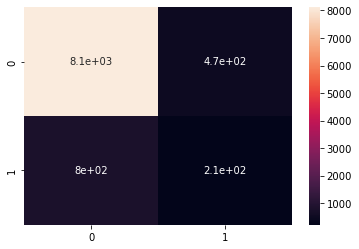

In [135]:
y_pred_vec_model_FF_3 = model_FF_3.predict(x_devel_ss_scaled)


y_pred_model_FF_3 = np.argmax(y_pred_vec_model_FF_3, axis=1)


acc_model_FF_3 = accuracy_score(y_devel, y_pred_model_FF_3)

print( "Classification accuracy is:  " + str(round(acc_model_FF_3,3)))

cm_model_FF_3 = confusion_matrix(y_devel, y_pred_model_FF_3)
sns.heatmap(cm_model_FF_3, annot=True)

In [136]:
classification_report_model_FF_3 = classification_report(y_devel, y_pred_model_FF_3)
print(classification_report_model_FF_3)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      8585
           1       0.31      0.21      0.25      1011

    accuracy                           0.87      9596
   macro avg       0.61      0.58      0.59      9596
weighted avg       0.85      0.87      0.86      9596



Feedforward Neural Network Model 4 with final activation function as softmax, epochs = 250, and batch size = 16

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 64)                5696      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 32)                2080      
                                                                 
 dense_39 (Dense)            (None, 2)                 66        
                                                                 
Total params: 7,842
Trainable params: 7,842
Non-trainable params: 0
_________________________________________________________________
None


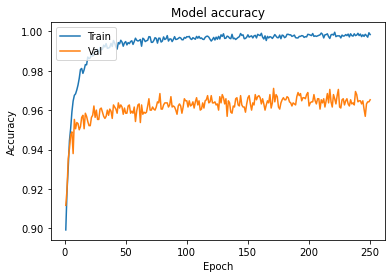

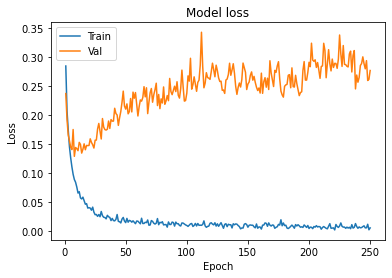

In [138]:
# model 4

def FF_4():
    model = Sequential()
    model.add(Dense(64, input_dim=n_features, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    print(model.summary())
    return model

model_FF_4 = FF_4()

model_FF_4.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 250
BATCH_SIZE = 16

history = model_FF_4.fit(
    x_train_ss_scaled, y_train_vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=0
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.877


<AxesSubplot:>

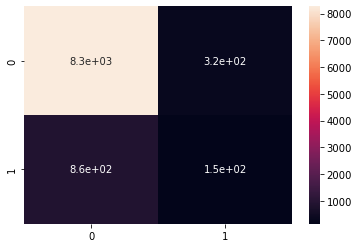

In [139]:
y_pred_vec_model_FF_4 = model_FF_4.predict(x_devel_ss_scaled)

y_pred_model_FF_4 = np.argmax(y_pred_vec_model_FF_4, axis=1)


acc_model_FF_4 = accuracy_score(y_devel, y_pred_model_FF_4)

print( "Classification accuracy is:  " + str(round(acc_model_FF_4,3)))

cm_model_FF_4 = confusion_matrix(y_devel, y_pred_model_FF_4)
sns.heatmap(cm_model_FF_4, annot=True)

In [140]:
classification_report_model_FF_4 = classification_report(y_devel, y_pred_model_FF_4)
print(classification_report_model_FF_4)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      8585
           1       0.31      0.14      0.20      1011

    accuracy                           0.88      9596
   macro avg       0.61      0.55      0.57      9596
weighted avg       0.84      0.88      0.86      9596



Feedforward Neural Network Model 5 with batch normalization (for regularization), epochs = 500 and batch size = 128

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 64)                5696      
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_51 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_52 (Dense)            (None, 16)                528       
                                                                 
 batch_normalization_5 (Batc  (None, 16)             

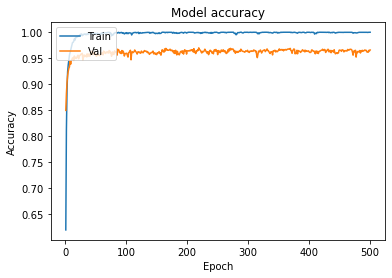

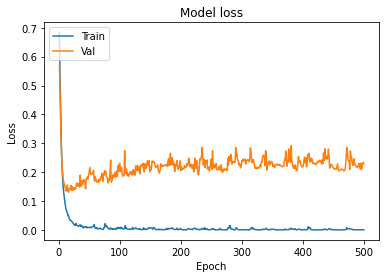

In [215]:
# model 5

def FF_5():
    model = Sequential()
    model.add(Dense(64, input_dim=n_features, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='sigmoid'))
    print(model.summary())
    return model

model_FF_5 = FF_5()

model_FF_5.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS = 500
BATCH_SIZE = 128

history = model_FF_5.fit(
    x_train_ss_scaled, y_train_vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=0
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.87


<AxesSubplot:>

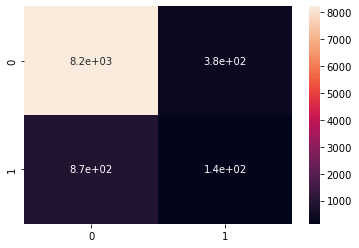

In [216]:
y_pred_vec_model_FF_5 = model_FF_5.predict(x_devel_ss_scaled)

y_pred_model_FF_5 = np.argmax(y_pred_vec_model_FF_5, axis=1)


acc_model_FF_5 = accuracy_score(y_devel, y_pred_model_FF_5)

print( "Classification accuracy is:  " + str(round(acc_model_FF_5,3)))

cm_model_FF_5 = confusion_matrix(y_devel, y_pred_model_FF_5)
sns.heatmap(cm_model_FF_5, annot=True)

In [217]:
classification_report_model_FF_5 = classification_report(y_devel, y_pred_model_FF_5)
print(classification_report_model_FF_5)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      8585
           1       0.27      0.14      0.18      1011

    accuracy                           0.87      9596
   macro avg       0.59      0.55      0.56      9596
weighted avg       0.84      0.87      0.85      9596



Convolutional neural networks

In [145]:
from keras.layers import Reshape

In [175]:
from keras.layers import InputLayer
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Normalization
from keras.layers import Dense
from keras.layers import Flatten

Check the output variable shape

In [150]:
y_train_vec.shape[1]

2

Reshaping the train data to fit in the CNN model, the data has 88 features which can be reshaped into (44, 2) or (22, 4) or any other combination that gives a multiplication product of 88

Convolutional neural network model 1: shape (44,2), two conv1D layers with activation function 'relu', Final activation function is sigmoid as this is a binary classification

In [188]:
def CNN_1():
    model = Sequential()
    model.add(Reshape((44,2), input_shape=(n_features,)))
    model.add(Conv1D(filters=32, kernel_size= 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size= 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(2, activation='sigmoid'))
    print(model.summary())
    return model

Optimizer: adam and loss function: binary crossentropy

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8 (Reshape)         (None, 44, 2)             0         
                                                                 
 conv1d_11 (Conv1D)          (None, 42, 32)            224       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 21, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 19, 64)            6208      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 9, 64)            0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 576)             

Epoch 55/250
238/238 - 1s - loss: 0.0397 - accuracy: 0.9908 - val_loss: 0.2593 - val_accuracy: 0.9379 - 902ms/epoch - 4ms/step
Epoch 56/250
238/238 - 1s - loss: 0.0389 - accuracy: 0.9950 - val_loss: 0.2274 - val_accuracy: 0.9374 - 838ms/epoch - 4ms/step
Epoch 57/250
238/238 - 1s - loss: 0.0225 - accuracy: 0.9962 - val_loss: 0.2178 - val_accuracy: 0.9453 - 1s/epoch - 4ms/step
Epoch 58/250
238/238 - 1s - loss: 0.0130 - accuracy: 0.9980 - val_loss: 0.2170 - val_accuracy: 0.9395 - 795ms/epoch - 3ms/step
Epoch 59/250
238/238 - 1s - loss: 0.0162 - accuracy: 0.9982 - val_loss: 0.2199 - val_accuracy: 0.9421 - 881ms/epoch - 4ms/step
Epoch 60/250
238/238 - 1s - loss: 0.0139 - accuracy: 0.9987 - val_loss: 0.2573 - val_accuracy: 0.9342 - 1s/epoch - 4ms/step
Epoch 61/250
238/238 - 1s - loss: 0.0124 - accuracy: 0.9986 - val_loss: 0.2173 - val_accuracy: 0.9474 - 1s/epoch - 4ms/step
Epoch 62/250
238/238 - 1s - loss: 0.0112 - accuracy: 0.9987 - val_loss: 0.2270 - val_accuracy: 0.9442 - 931ms/epoch - 4m

Epoch 120/250
238/238 - 1s - loss: 5.4674e-04 - accuracy: 1.0000 - val_loss: 0.3081 - val_accuracy: 0.9490 - 947ms/epoch - 4ms/step
Epoch 121/250
238/238 - 1s - loss: 5.0975e-04 - accuracy: 1.0000 - val_loss: 0.3062 - val_accuracy: 0.9484 - 927ms/epoch - 4ms/step
Epoch 122/250
238/238 - 1s - loss: 4.8476e-04 - accuracy: 1.0000 - val_loss: 0.3151 - val_accuracy: 0.9474 - 797ms/epoch - 3ms/step
Epoch 123/250
238/238 - 1s - loss: 4.7454e-04 - accuracy: 1.0000 - val_loss: 0.3101 - val_accuracy: 0.9469 - 808ms/epoch - 3ms/step
Epoch 124/250
238/238 - 1s - loss: 4.4519e-04 - accuracy: 1.0000 - val_loss: 0.3163 - val_accuracy: 0.9474 - 914ms/epoch - 4ms/step
Epoch 125/250
238/238 - 1s - loss: 4.1358e-04 - accuracy: 1.0000 - val_loss: 0.3185 - val_accuracy: 0.9484 - 982ms/epoch - 4ms/step
Epoch 126/250
238/238 - 1s - loss: 4.1251e-04 - accuracy: 1.0000 - val_loss: 0.3205 - val_accuracy: 0.9484 - 783ms/epoch - 3ms/step
Epoch 127/250
238/238 - 1s - loss: 3.7875e-04 - accuracy: 1.0000 - val_loss:

Epoch 183/250
238/238 - 1s - loss: 1.3465e-04 - accuracy: 1.0000 - val_loss: 0.3547 - val_accuracy: 0.9479 - 810ms/epoch - 3ms/step
Epoch 184/250
238/238 - 1s - loss: 1.2596e-04 - accuracy: 1.0000 - val_loss: 0.3563 - val_accuracy: 0.9474 - 920ms/epoch - 4ms/step
Epoch 185/250
238/238 - 1s - loss: 1.1946e-04 - accuracy: 1.0000 - val_loss: 0.3546 - val_accuracy: 0.9490 - 755ms/epoch - 3ms/step
Epoch 186/250
238/238 - 1s - loss: 1.1282e-04 - accuracy: 1.0000 - val_loss: 0.3569 - val_accuracy: 0.9490 - 912ms/epoch - 4ms/step
Epoch 187/250
238/238 - 1s - loss: 1.0685e-04 - accuracy: 1.0000 - val_loss: 0.3589 - val_accuracy: 0.9490 - 807ms/epoch - 3ms/step
Epoch 188/250
238/238 - 1s - loss: 1.0078e-04 - accuracy: 1.0000 - val_loss: 0.3622 - val_accuracy: 0.9469 - 919ms/epoch - 4ms/step
Epoch 189/250
238/238 - 1s - loss: 9.4275e-05 - accuracy: 1.0000 - val_loss: 0.3618 - val_accuracy: 0.9490 - 894ms/epoch - 4ms/step
Epoch 190/250
238/238 - 1s - loss: 9.0858e-05 - accuracy: 1.0000 - val_loss:

Epoch 246/250
238/238 - 1s - loss: 1.7896e-05 - accuracy: 1.0000 - val_loss: 0.4202 - val_accuracy: 0.9511 - 922ms/epoch - 4ms/step
Epoch 247/250
238/238 - 1s - loss: 1.6163e-05 - accuracy: 1.0000 - val_loss: 0.4231 - val_accuracy: 0.9495 - 820ms/epoch - 3ms/step
Epoch 248/250
238/238 - 1s - loss: 1.5871e-05 - accuracy: 1.0000 - val_loss: 0.4223 - val_accuracy: 0.9453 - 998ms/epoch - 4ms/step
Epoch 249/250
238/238 - 1s - loss: 1.4694e-05 - accuracy: 1.0000 - val_loss: 0.4281 - val_accuracy: 0.9484 - 1s/epoch - 4ms/step
Epoch 250/250
238/238 - 1s - loss: 1.3569e-05 - accuracy: 1.0000 - val_loss: 0.4329 - val_accuracy: 0.9469 - 771ms/epoch - 3ms/step


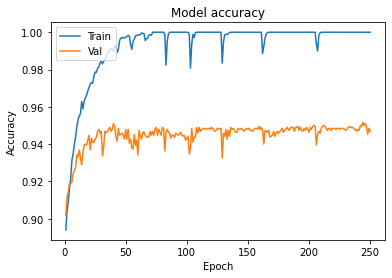

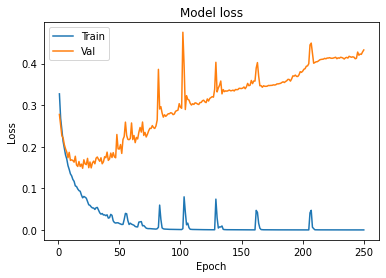

In [189]:
model_CNN_1 = CNN_1()

model_CNN_1.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS = 250
BATCH_SIZE = 32

history = model_CNN_1.fit(
    x_train_ss_scaled, y_train_vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=2
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.873


<AxesSubplot:>

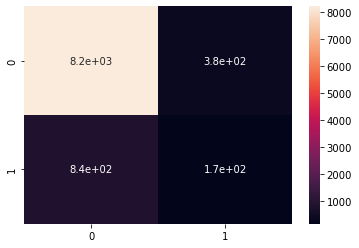

In [190]:
y_pred_vec_CNN_1 = model_CNN_1.predict(x_devel_ss_scaled)

# This line converts the softmax output back to a single column array
y_pred_CNN_1 = np.argmax(y_pred_vec_CNN_1, axis=1)


acc_CNN_1 = accuracy_score(y_devel, y_pred_CNN_1)

print( "Classification accuracy is:  " + str(round(acc_CNN_1,3)))

cm_CNN_1 = confusion_matrix(y_devel, y_pred_CNN_1)
sns.heatmap(cm_CNN_1, annot=True)

In [191]:
classification_report_CNN_1 = classification_report(y_devel, y_pred_CNN_1)
print(classification_report_CNN_1)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      8585
           1       0.31      0.17      0.22      1011

    accuracy                           0.87      9596
   macro avg       0.61      0.56      0.58      9596
weighted avg       0.84      0.87      0.86      9596



Convolutional neural network model 2 : Adding batch normalization (for regularization) and three conv1D layers, epochs= 200, batch size = 64

In [195]:
from keras.layers import BatchNormalization

In [196]:
def CNN_2():
    model = Sequential()
    model.add(Reshape((44,2), input_shape=(n_features,)))
    model.add(Conv1D(filters=32, kernel_size= 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size= 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=128, kernel_size= 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(2, activation='sigmoid'))
    print(model.summary())
    return model

Optimizer: rmsprop and loss function: binary crossentropy

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_10 (Reshape)        (None, 44, 2)             0         
                                                                 
 conv1d_14 (Conv1D)          (None, 42, 32)            224       
                                                                 
 batch_normalization (BatchN  (None, 42, 32)           128       
 ormalization)                                                   
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 21, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, 19, 64)            6208      
                                                                 
 batch_normalization_1 (Batc  (None, 19, 64)         

Epoch 48/200
119/119 - 1s - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.2864 - val_accuracy: 0.9521 - 884ms/epoch - 7ms/step
Epoch 49/200
119/119 - 1s - loss: 0.0030 - accuracy: 0.9989 - val_loss: 0.2990 - val_accuracy: 0.9469 - 1s/epoch - 11ms/step
Epoch 50/200
119/119 - 1s - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.3347 - val_accuracy: 0.9406 - 1s/epoch - 11ms/step
Epoch 51/200
119/119 - 1s - loss: 0.0031 - accuracy: 0.9988 - val_loss: 0.3309 - val_accuracy: 0.9516 - 1s/epoch - 11ms/step
Epoch 52/200
119/119 - 1s - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.3111 - val_accuracy: 0.9484 - 1s/epoch - 12ms/step
Epoch 53/200
119/119 - 2s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.2740 - val_accuracy: 0.9506 - 2s/epoch - 13ms/step
Epoch 54/200
119/119 - 1s - loss: 0.0039 - accuracy: 0.9993 - val_loss: 0.3007 - val_accuracy: 0.9484 - 1s/epoch - 10ms/step
Epoch 55/200
119/119 - 2s - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.2819 - val_accuracy: 0.9516 - 2s/epoch - 14ms/ste

Epoch 113/200
119/119 - 1s - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.4236 - val_accuracy: 0.9532 - 1s/epoch - 9ms/step
Epoch 114/200
119/119 - 2s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.4152 - val_accuracy: 0.9506 - 2s/epoch - 13ms/step
Epoch 115/200
119/119 - 1s - loss: 2.6752e-04 - accuracy: 1.0000 - val_loss: 0.4015 - val_accuracy: 0.9453 - 1s/epoch - 9ms/step
Epoch 116/200
119/119 - 2s - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.3928 - val_accuracy: 0.9490 - 2s/epoch - 15ms/step
Epoch 117/200
119/119 - 1s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.4899 - val_accuracy: 0.9453 - 1s/epoch - 11ms/step
Epoch 118/200
119/119 - 1s - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.4322 - val_accuracy: 0.9558 - 1s/epoch - 12ms/step
Epoch 119/200
119/119 - 1s - loss: 4.2838e-04 - accuracy: 0.9997 - val_loss: 0.4219 - val_accuracy: 0.9490 - 914ms/epoch - 8ms/step
Epoch 120/200
119/119 - 1s - loss: 9.5520e-04 - accuracy: 0.9999 - val_loss: 0.4049 - val_accuracy: 0.9490 - 1

Epoch 177/200
119/119 - 1s - loss: 3.5747e-04 - accuracy: 0.9997 - val_loss: 0.4705 - val_accuracy: 0.9521 - 1s/epoch - 10ms/step
Epoch 178/200
119/119 - 1s - loss: 2.8573e-04 - accuracy: 0.9997 - val_loss: 0.4611 - val_accuracy: 0.9442 - 1s/epoch - 10ms/step
Epoch 179/200
119/119 - 1s - loss: 3.4213e-04 - accuracy: 0.9999 - val_loss: 0.4435 - val_accuracy: 0.9495 - 941ms/epoch - 8ms/step
Epoch 180/200
119/119 - 2s - loss: 1.7772e-05 - accuracy: 1.0000 - val_loss: 0.4269 - val_accuracy: 0.9484 - 2s/epoch - 13ms/step
Epoch 181/200
119/119 - 1s - loss: 2.6194e-05 - accuracy: 1.0000 - val_loss: 0.4686 - val_accuracy: 0.9484 - 963ms/epoch - 8ms/step
Epoch 182/200
119/119 - 1s - loss: 2.4464e-04 - accuracy: 0.9999 - val_loss: 0.4670 - val_accuracy: 0.9474 - 1s/epoch - 10ms/step
Epoch 183/200
119/119 - 1s - loss: 4.5948e-04 - accuracy: 0.9999 - val_loss: 0.4389 - val_accuracy: 0.9511 - 1s/epoch - 10ms/step
Epoch 184/200
119/119 - 1s - loss: 6.8791e-04 - accuracy: 0.9999 - val_loss: 0.4743 - 

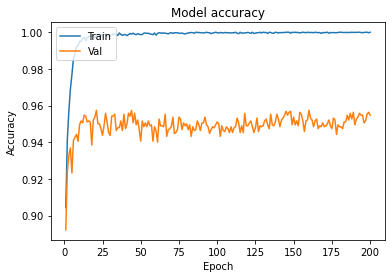

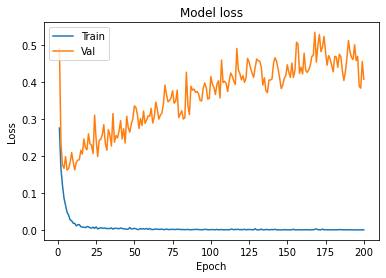

In [197]:
model_CNN_2 = CNN_2()

model_CNN_2.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS = 200
BATCH_SIZE = 64

history = model_CNN_2.fit(
    x_train_ss_scaled, y_train_vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=2
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.874


<AxesSubplot:>

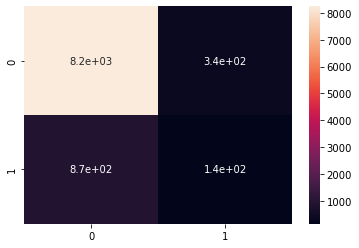

In [198]:
y_pred_vec_CNN_2 = model_CNN_2.predict(x_devel_ss_scaled)

# This line converts the softmax output back to a single column array
y_pred_CNN_2 = np.argmax(y_pred_vec_CNN_2, axis=1)


acc_CNN_2 = accuracy_score(y_devel, y_pred_CNN_2)

print( "Classification accuracy is:  " + str(round(acc_CNN_2,3)))

cm_CNN_2 = confusion_matrix(y_devel, y_pred_CNN_2)
sns.heatmap(cm_CNN_2, annot=True)

In [199]:
classification_report_CNN_2 = classification_report(y_devel, y_pred_CNN_2)
print(classification_report_CNN_2)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      8585
           1       0.29      0.14      0.18      1011

    accuracy                           0.87      9596
   macro avg       0.60      0.55      0.56      9596
weighted avg       0.84      0.87      0.85      9596



Convolutional neural network model 3: Adding dropout (for regularization), epochs = 100, batch size = 128

In [200]:
# model 3

def CNN_3():
    model = Sequential()
    model.add(Reshape((44,2), input_shape=(n_features,)))
    model.add(Conv1D(filters=16, kernel_size= 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=32, kernel_size= 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=64, kernel_size= 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(2, activation='sigmoid'))
    print(model.summary())
    return model

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_11 (Reshape)        (None, 44, 2)             0         
                                                                 
 conv1d_17 (Conv1D)          (None, 42, 16)            112       
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 21, 16)           0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 21, 16)            0         
                                                                 
 conv1d_18 (Conv1D)          (None, 19, 32)            1568      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                

Epoch 49/100
60/60 - 0s - loss: 0.1843 - accuracy: 0.9277 - val_loss: 0.1770 - val_accuracy: 0.9374 - 455ms/epoch - 8ms/step
Epoch 50/100
60/60 - 0s - loss: 0.1872 - accuracy: 0.9262 - val_loss: 0.1620 - val_accuracy: 0.9395 - 473ms/epoch - 8ms/step
Epoch 51/100
60/60 - 0s - loss: 0.1902 - accuracy: 0.9252 - val_loss: 0.1653 - val_accuracy: 0.9406 - 434ms/epoch - 7ms/step
Epoch 52/100
60/60 - 0s - loss: 0.1792 - accuracy: 0.9299 - val_loss: 0.1642 - val_accuracy: 0.9400 - 442ms/epoch - 7ms/step
Epoch 53/100
60/60 - 0s - loss: 0.1814 - accuracy: 0.9281 - val_loss: 0.1658 - val_accuracy: 0.9411 - 429ms/epoch - 7ms/step
Epoch 54/100
60/60 - 0s - loss: 0.1792 - accuracy: 0.9300 - val_loss: 0.1830 - val_accuracy: 0.9358 - 446ms/epoch - 7ms/step
Epoch 55/100
60/60 - 0s - loss: 0.1787 - accuracy: 0.9310 - val_loss: 0.1668 - val_accuracy: 0.9385 - 424ms/epoch - 7ms/step
Epoch 56/100
60/60 - 0s - loss: 0.1823 - accuracy: 0.9306 - val_loss: 0.1670 - val_accuracy: 0.9390 - 491ms/epoch - 8ms/step


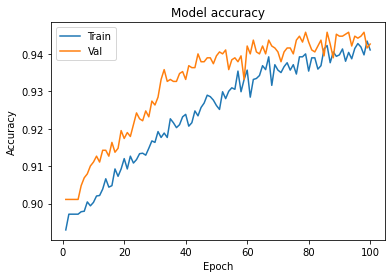

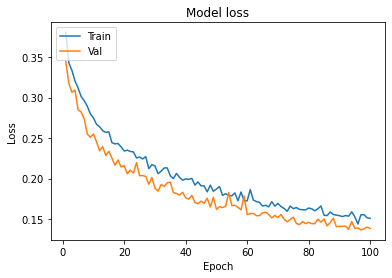

In [201]:
model_CNN_3 = CNN_3()

model_CNN_3.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS = 100
BATCH_SIZE = 128

history = model_CNN_3.fit(
    x_train_ss_scaled, y_train_vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=2
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.884


<AxesSubplot:>

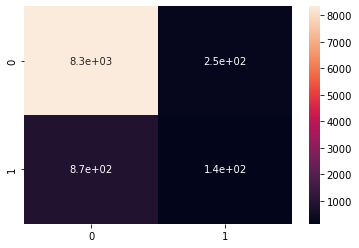

In [202]:
y_pred_vec_CNN_3 = model_CNN_3.predict(x_devel_ss_scaled)

# This line converts the softmax output back to a single column array
y_pred_CNN_3 = np.argmax(y_pred_vec_CNN_3, axis=1)


acc_CNN_3 = accuracy_score(y_devel, y_pred_CNN_3)

print( "Classification accuracy is:  " + str(round(acc_CNN_3,3)))

cm_CNN_3 = confusion_matrix(y_devel, y_pred_CNN_3)
sns.heatmap(cm_CNN_3, annot=True)

In [203]:
classification_report_CNN_3 = classification_report(y_devel, y_pred_CNN_3)
print(classification_report_CNN_3)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      8585
           1       0.36      0.14      0.20      1011

    accuracy                           0.88      9596
   macro avg       0.63      0.55      0.57      9596
weighted avg       0.85      0.88      0.86      9596



Convolutional neural network model 4: Changing the shape of input to (22, 4), epochs = 250 and batch size = 32

In [204]:
# 4th model

def CNN_4():
    model = Sequential()
    model.add(Reshape((22,4), input_shape=(n_features,)))
    model.add(Conv1D(filters=32, kernel_size= 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size= 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(2, activation='sigmoid'))
    print(model.summary())
    return model

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_12 (Reshape)        (None, 22, 4)             0         
                                                                 
 conv1d_20 (Conv1D)          (None, 20, 32)            416       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 10, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 8, 64)             6208      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 4, 64)            0         
 g1D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 256)             

Epoch 54/250
238/238 - 1s - loss: 0.0138 - accuracy: 0.9989 - val_loss: 0.2015 - val_accuracy: 0.9521 - 618ms/epoch - 3ms/step
Epoch 55/250
238/238 - 1s - loss: 0.0106 - accuracy: 0.9988 - val_loss: 0.2053 - val_accuracy: 0.9500 - 589ms/epoch - 2ms/step
Epoch 56/250
238/238 - 1s - loss: 0.0137 - accuracy: 0.9993 - val_loss: 0.1982 - val_accuracy: 0.9521 - 512ms/epoch - 2ms/step
Epoch 57/250
238/238 - 1s - loss: 0.0134 - accuracy: 0.9992 - val_loss: 0.2097 - val_accuracy: 0.9479 - 543ms/epoch - 2ms/step
Epoch 58/250
238/238 - 1s - loss: 0.0290 - accuracy: 0.9942 - val_loss: 0.2326 - val_accuracy: 0.9516 - 531ms/epoch - 2ms/step
Epoch 59/250
238/238 - 1s - loss: 0.0289 - accuracy: 0.9955 - val_loss: 0.2222 - val_accuracy: 0.9458 - 501ms/epoch - 2ms/step
Epoch 60/250
238/238 - 1s - loss: 0.0111 - accuracy: 0.9992 - val_loss: 0.2152 - val_accuracy: 0.9563 - 563ms/epoch - 2ms/step
Epoch 61/250
238/238 - 0s - loss: 0.0085 - accuracy: 0.9993 - val_loss: 0.2083 - val_accuracy: 0.9537 - 491ms/e

Epoch 118/250
238/238 - 0s - loss: 3.6871e-04 - accuracy: 1.0000 - val_loss: 0.2824 - val_accuracy: 0.9553 - 475ms/epoch - 2ms/step
Epoch 119/250
238/238 - 0s - loss: 3.4277e-04 - accuracy: 1.0000 - val_loss: 0.2846 - val_accuracy: 0.9537 - 497ms/epoch - 2ms/step
Epoch 120/250
238/238 - 1s - loss: 3.2041e-04 - accuracy: 1.0000 - val_loss: 0.2853 - val_accuracy: 0.9537 - 515ms/epoch - 2ms/step
Epoch 121/250
238/238 - 1s - loss: 3.0585e-04 - accuracy: 1.0000 - val_loss: 0.2876 - val_accuracy: 0.9548 - 552ms/epoch - 2ms/step
Epoch 122/250
238/238 - 0s - loss: 2.7716e-04 - accuracy: 1.0000 - val_loss: 0.2884 - val_accuracy: 0.9532 - 475ms/epoch - 2ms/step
Epoch 123/250
238/238 - 1s - loss: 2.6010e-04 - accuracy: 1.0000 - val_loss: 0.2931 - val_accuracy: 0.9527 - 566ms/epoch - 2ms/step
Epoch 124/250
238/238 - 0s - loss: 2.5149e-04 - accuracy: 1.0000 - val_loss: 0.2936 - val_accuracy: 0.9553 - 475ms/epoch - 2ms/step
Epoch 125/250
238/238 - 1s - loss: 2.4835e-04 - accuracy: 1.0000 - val_loss:

Epoch 181/250
238/238 - 1s - loss: 0.0102 - accuracy: 0.9968 - val_loss: 0.4461 - val_accuracy: 0.9463 - 552ms/epoch - 2ms/step
Epoch 182/250
238/238 - 1s - loss: 0.0111 - accuracy: 0.9974 - val_loss: 0.4665 - val_accuracy: 0.9500 - 512ms/epoch - 2ms/step
Epoch 183/250
238/238 - 0s - loss: 0.0237 - accuracy: 0.9996 - val_loss: 0.3808 - val_accuracy: 0.9511 - 481ms/epoch - 2ms/step
Epoch 184/250
238/238 - 0s - loss: 0.0210 - accuracy: 0.9991 - val_loss: 0.3821 - val_accuracy: 0.9516 - 482ms/epoch - 2ms/step
Epoch 185/250
238/238 - 1s - loss: 3.1004e-04 - accuracy: 1.0000 - val_loss: 0.3685 - val_accuracy: 0.9532 - 551ms/epoch - 2ms/step
Epoch 186/250
238/238 - 1s - loss: 1.6441e-04 - accuracy: 1.0000 - val_loss: 0.3678 - val_accuracy: 0.9532 - 536ms/epoch - 2ms/step
Epoch 187/250
238/238 - 1s - loss: 1.3479e-04 - accuracy: 1.0000 - val_loss: 0.3676 - val_accuracy: 0.9532 - 523ms/epoch - 2ms/step
Epoch 188/250
238/238 - 0s - loss: 1.2034e-04 - accuracy: 1.0000 - val_loss: 0.3674 - val_ac

Epoch 244/250
238/238 - 1s - loss: 5.3467e-05 - accuracy: 1.0000 - val_loss: 0.3994 - val_accuracy: 0.9553 - 627ms/epoch - 3ms/step
Epoch 245/250
238/238 - 0s - loss: 5.0258e-05 - accuracy: 1.0000 - val_loss: 0.3997 - val_accuracy: 0.9542 - 484ms/epoch - 2ms/step
Epoch 246/250
238/238 - 1s - loss: 4.6082e-05 - accuracy: 1.0000 - val_loss: 0.4004 - val_accuracy: 0.9537 - 522ms/epoch - 2ms/step
Epoch 247/250
238/238 - 1s - loss: 4.2647e-05 - accuracy: 1.0000 - val_loss: 0.4006 - val_accuracy: 0.9537 - 557ms/epoch - 2ms/step
Epoch 248/250
238/238 - 1s - loss: 4.0011e-05 - accuracy: 1.0000 - val_loss: 0.4007 - val_accuracy: 0.9537 - 515ms/epoch - 2ms/step
Epoch 249/250
238/238 - 0s - loss: 3.7525e-05 - accuracy: 1.0000 - val_loss: 0.4013 - val_accuracy: 0.9537 - 456ms/epoch - 2ms/step
Epoch 250/250
238/238 - 0s - loss: 3.4991e-05 - accuracy: 1.0000 - val_loss: 0.4018 - val_accuracy: 0.9537 - 475ms/epoch - 2ms/step


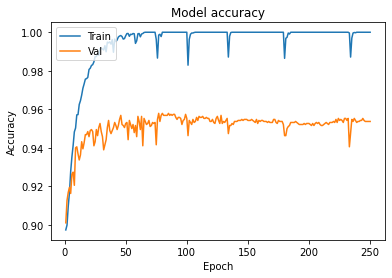

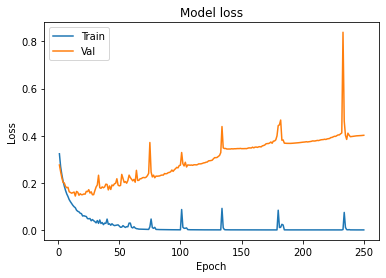

In [205]:
model_CNN_4 = CNN_4()

model_CNN_4.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS = 250
BATCH_SIZE = 32

history = model_CNN_4.fit(
    x_train_ss_scaled, y_train_vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=2
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.875


<AxesSubplot:>

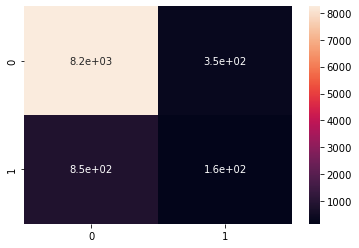

In [206]:
y_pred_vec_CNN_4 = model_CNN_4.predict(x_devel_ss_scaled)

# This line converts the softmax output back to a single column array
y_pred_CNN_4 = np.argmax(y_pred_vec_CNN_4, axis=1)


acc_CNN_4 = accuracy_score(y_devel, y_pred_CNN_4)

print( "Classification accuracy is:  " + str(round(acc_CNN_4,3)))

cm_CNN_4 = confusion_matrix(y_devel, y_pred_CNN_4)
sns.heatmap(cm_CNN_4, annot=True)

In [207]:
classification_report_CNN_4 = classification_report(y_devel, y_pred_CNN_4)
print(classification_report_CNN_4)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      8585
           1       0.32      0.16      0.21      1011

    accuracy                           0.88      9596
   macro avg       0.61      0.56      0.57      9596
weighted avg       0.84      0.88      0.86      9596



Convolutional neural network model 5: Changing the shape of the input to (11, 8) and using final activation function as softmax

In [212]:
# 5th model

def CNN_5():
    model = Sequential()
    model.add(Reshape((11,8), input_shape=(n_features,)))
    model.add(Conv1D(filters=32, kernel_size= 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=64, kernel_size= 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    print(model.summary())
    return model

Optimizer: adam and loss function: categorical crossentropy, epochs = 250 and batch size = 64

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_14 (Reshape)        (None, 11, 8)             0         
                                                                 
 conv1d_24 (Conv1D)          (None, 9, 32)             800       
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 4, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 2, 64)             6208      
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 64)              

Epoch 54/250
119/119 - 0s - loss: 0.0091 - accuracy: 0.9995 - val_loss: 0.1809 - val_accuracy: 0.9506 - 237ms/epoch - 2ms/step
Epoch 55/250
119/119 - 0s - loss: 0.0257 - accuracy: 0.9972 - val_loss: 0.2028 - val_accuracy: 0.9437 - 294ms/epoch - 2ms/step
Epoch 56/250
119/119 - 0s - loss: 0.0076 - accuracy: 0.9997 - val_loss: 0.1816 - val_accuracy: 0.9484 - 333ms/epoch - 3ms/step
Epoch 57/250
119/119 - 0s - loss: 0.0068 - accuracy: 0.9996 - val_loss: 0.1811 - val_accuracy: 0.9479 - 246ms/epoch - 2ms/step
Epoch 58/250
119/119 - 0s - loss: 0.0053 - accuracy: 0.9999 - val_loss: 0.1855 - val_accuracy: 0.9521 - 232ms/epoch - 2ms/step
Epoch 59/250
119/119 - 0s - loss: 0.0048 - accuracy: 0.9999 - val_loss: 0.1862 - val_accuracy: 0.9484 - 259ms/epoch - 2ms/step
Epoch 60/250
119/119 - 0s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.1871 - val_accuracy: 0.9463 - 297ms/epoch - 2ms/step
Epoch 61/250
119/119 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.1860 - val_accuracy: 0.9469 - 233ms/e

Epoch 118/250
119/119 - 0s - loss: 0.0102 - accuracy: 0.9995 - val_loss: 0.3055 - val_accuracy: 0.9437 - 258ms/epoch - 2ms/step
Epoch 119/250
119/119 - 0s - loss: 0.0034 - accuracy: 0.9988 - val_loss: 0.3089 - val_accuracy: 0.9474 - 242ms/epoch - 2ms/step
Epoch 120/250
119/119 - 0s - loss: 8.8732e-04 - accuracy: 1.0000 - val_loss: 0.2954 - val_accuracy: 0.9500 - 257ms/epoch - 2ms/step
Epoch 121/250
119/119 - 0s - loss: 5.8603e-04 - accuracy: 1.0000 - val_loss: 0.2925 - val_accuracy: 0.9479 - 238ms/epoch - 2ms/step
Epoch 122/250
119/119 - 0s - loss: 5.2082e-04 - accuracy: 1.0000 - val_loss: 0.2922 - val_accuracy: 0.9500 - 238ms/epoch - 2ms/step
Epoch 123/250
119/119 - 0s - loss: 4.8986e-04 - accuracy: 1.0000 - val_loss: 0.2910 - val_accuracy: 0.9490 - 237ms/epoch - 2ms/step
Epoch 124/250
119/119 - 0s - loss: 4.4972e-04 - accuracy: 1.0000 - val_loss: 0.2905 - val_accuracy: 0.9506 - 235ms/epoch - 2ms/step
Epoch 125/250
119/119 - 0s - loss: 4.2424e-04 - accuracy: 1.0000 - val_loss: 0.2910 

Epoch 181/250
119/119 - 0s - loss: 3.8753e-05 - accuracy: 1.0000 - val_loss: 0.3480 - val_accuracy: 0.9479 - 242ms/epoch - 2ms/step
Epoch 182/250
119/119 - 0s - loss: 3.6574e-05 - accuracy: 1.0000 - val_loss: 0.3466 - val_accuracy: 0.9463 - 253ms/epoch - 2ms/step
Epoch 183/250
119/119 - 0s - loss: 3.4982e-05 - accuracy: 1.0000 - val_loss: 0.3515 - val_accuracy: 0.9479 - 262ms/epoch - 2ms/step
Epoch 184/250
119/119 - 0s - loss: 3.3711e-05 - accuracy: 1.0000 - val_loss: 0.3535 - val_accuracy: 0.9474 - 227ms/epoch - 2ms/step
Epoch 185/250
119/119 - 0s - loss: 3.2518e-05 - accuracy: 1.0000 - val_loss: 0.3586 - val_accuracy: 0.9490 - 249ms/epoch - 2ms/step
Epoch 186/250
119/119 - 0s - loss: 2.9728e-05 - accuracy: 1.0000 - val_loss: 0.3561 - val_accuracy: 0.9490 - 228ms/epoch - 2ms/step
Epoch 187/250
119/119 - 0s - loss: 2.7889e-05 - accuracy: 1.0000 - val_loss: 0.3607 - val_accuracy: 0.9479 - 222ms/epoch - 2ms/step
Epoch 188/250
119/119 - 0s - loss: 2.7283e-05 - accuracy: 1.0000 - val_loss:

Epoch 244/250
119/119 - 0s - loss: 3.0825e-05 - accuracy: 1.0000 - val_loss: 0.4268 - val_accuracy: 0.9474 - 230ms/epoch - 2ms/step
Epoch 245/250
119/119 - 0s - loss: 2.9621e-05 - accuracy: 1.0000 - val_loss: 0.4278 - val_accuracy: 0.9474 - 242ms/epoch - 2ms/step
Epoch 246/250
119/119 - 0s - loss: 2.8780e-05 - accuracy: 1.0000 - val_loss: 0.4268 - val_accuracy: 0.9479 - 255ms/epoch - 2ms/step
Epoch 247/250
119/119 - 0s - loss: 2.7695e-05 - accuracy: 1.0000 - val_loss: 0.4273 - val_accuracy: 0.9479 - 220ms/epoch - 2ms/step
Epoch 248/250
119/119 - 0s - loss: 2.6829e-05 - accuracy: 1.0000 - val_loss: 0.4276 - val_accuracy: 0.9479 - 301ms/epoch - 3ms/step
Epoch 249/250
119/119 - 0s - loss: 2.5663e-05 - accuracy: 1.0000 - val_loss: 0.4277 - val_accuracy: 0.9474 - 232ms/epoch - 2ms/step
Epoch 250/250
119/119 - 0s - loss: 2.4991e-05 - accuracy: 1.0000 - val_loss: 0.4282 - val_accuracy: 0.9474 - 205ms/epoch - 2ms/step


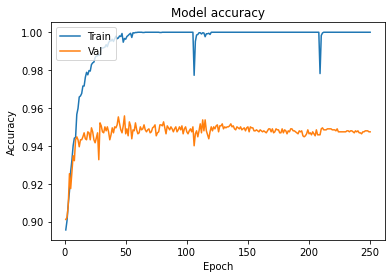

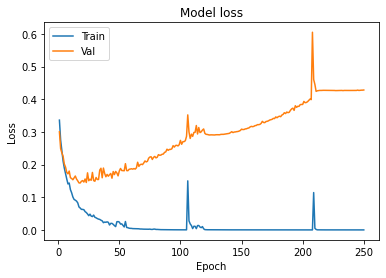

In [213]:
model_CNN_5 = CNN_5()

model_CNN_5.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 250
BATCH_SIZE = 64

history = model_CNN_5.fit(
    x_train_ss_scaled, y_train_vec, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=2
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.87


<AxesSubplot:>

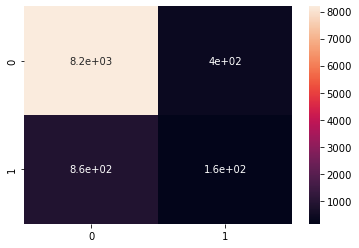

In [210]:
y_pred_vec_CNN_5 = model_CNN_5.predict(x_devel_ss_scaled)

# This line converts the softmax output back to a single column array
y_pred_CNN_5 = np.argmax(y_pred_vec_CNN_5, axis=1)


acc_CNN_5 = accuracy_score(y_devel, y_pred_CNN_5)

print( "Classification accuracy is:  " + str(round(acc_CNN_5,3)))

cm_CNN_5 = confusion_matrix(y_devel, y_pred_CNN_5)
sns.heatmap(cm_CNN_5, annot=True)

In [211]:
classification_report_CNN_5 = classification_report(y_devel, y_pred_CNN_5)
print(classification_report_CNN_5)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      8585
           1       0.28      0.15      0.20      1011

    accuracy                           0.87      9596
   macro avg       0.59      0.55      0.56      9596
weighted avg       0.84      0.87      0.85      9596



Applying class imbalance techniques : Done on top 3 models from FFNN (FF2 and FF3) and CNN (CNN1) based the observed F1 score for class 1 (cold)

Random Undersampling

In [218]:
Counter(y_train)

Counter({1: 970, 0: 8535})

In [219]:
# fit and transorm
x_under_ss, y_under_ss = undersample.fit_resample(x_train_ss_scaled, y_train)

In [220]:
Counter(y_under_ss)

Counter({0: 970, 1: 970})

In [221]:
y_train_vec_under = to_categorical(y_under_ss, 2)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 64)                5696      
                                                                 
 dense_59 (Dense)            (None, 32)                2080      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_60 (Dense)            (None, 16)                528       
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_61 (Dense)            (None, 2)                 34        
                                                                 
Total params: 8,338
Trainable params: 8,338
Non-train

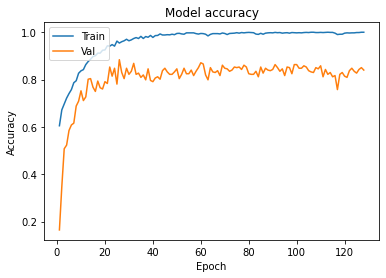

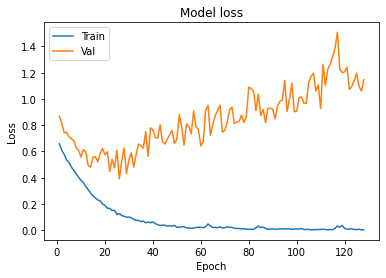

In [224]:
# model FF2

model_FF_2_under = FF_2()

model_FF_2_under.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS = 128
BATCH_SIZE = 64

history = model_FF_2_under.fit(
    x_under_ss, y_train_vec_under, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=0
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.83


<AxesSubplot:>

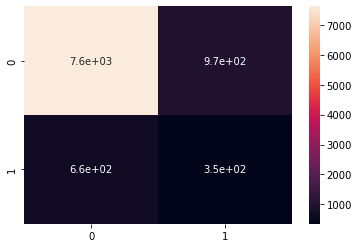

In [225]:
y_pred_vec_model_FF_2_under = model_FF_2_under.predict(x_devel_ss_scaled)

y_pred_model_FF_2_under = np.argmax(y_pred_vec_model_FF_2_under, axis=1)


acc_model_FF_2_under = accuracy_score(y_devel, y_pred_model_FF_2_under)

print( "Classification accuracy is:  " + str(round(acc_model_FF_2_under,3)))

cm_model_FF_2_under = confusion_matrix(y_devel, y_pred_model_FF_2_under)
sns.heatmap(cm_model_FF_2_under, annot=True)

In [226]:
classification_report_model_FF_2_under = classification_report(y_devel, y_pred_model_FF_2_under)
print(classification_report_model_FF_2_under)

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      8585
           1       0.27      0.35      0.30      1011

    accuracy                           0.83      9596
   macro avg       0.59      0.62      0.60      9596
weighted avg       0.85      0.83      0.84      9596



Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 64)                5696      
                                                                 
 dense_63 (Dense)            (None, 32)                2080      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_64 (Dense)            (None, 2)                 66        
                                                                 
Total params: 7,842
Trainable params: 7,842
Non-trainable params: 0
_________________________________________________________________
None


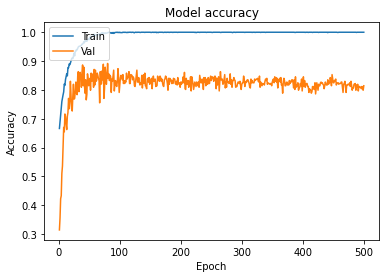

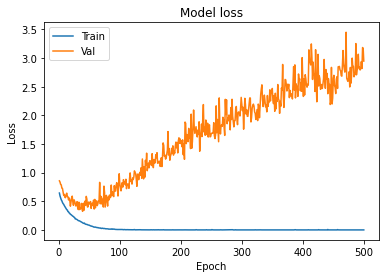

In [227]:
# With model FF3

model_FF_3_under = FF_3()

model_FF_3_under.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS = 500
BATCH_SIZE = 128

history = model_FF_3_under.fit(
    x_under_ss, y_train_vec_under, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=0
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.821


<AxesSubplot:>

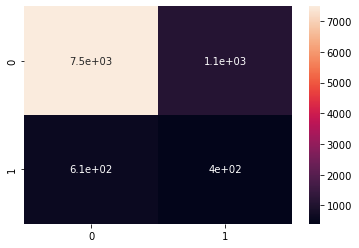

In [228]:
y_pred_vec_model_FF_3_under = model_FF_3_under.predict(x_devel_ss_scaled)

y_pred_model_FF_3_under = np.argmax(y_pred_vec_model_FF_3_under, axis=1)


acc_model_FF_3_under = accuracy_score(y_devel, y_pred_model_FF_3_under)

print( "Classification accuracy is:  " + str(round(acc_model_FF_3_under,3)))

cm_model_FF_3_under = confusion_matrix(y_devel, y_pred_model_FF_3_under)
sns.heatmap(cm_model_FF_3_under, annot=True)

In [229]:
classification_report_model_FF_3_under = classification_report(y_devel, y_pred_model_FF_3_under)
print(classification_report_model_FF_3_under)

              precision    recall  f1-score   support

           0       0.92      0.87      0.90      8585
           1       0.27      0.40      0.32      1011

    accuracy                           0.82      9596
   macro avg       0.60      0.63      0.61      9596
weighted avg       0.86      0.82      0.84      9596



Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_16 (Reshape)        (None, 44, 2)             0         
                                                                 
 conv1d_28 (Conv1D)          (None, 42, 32)            224       
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 21, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 19, 64)            6208      
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 9, 64)            0         
 g1D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 576)             

Epoch 55/250
49/49 - 0s - loss: 0.0285 - accuracy: 0.9994 - val_loss: 0.6835 - val_accuracy: 0.7706 - 166ms/epoch - 3ms/step
Epoch 56/250
49/49 - 0s - loss: 0.0267 - accuracy: 0.9994 - val_loss: 0.4885 - val_accuracy: 0.8454 - 179ms/epoch - 4ms/step
Epoch 57/250
49/49 - 0s - loss: 0.0249 - accuracy: 0.9987 - val_loss: 0.4538 - val_accuracy: 0.8608 - 214ms/epoch - 4ms/step
Epoch 58/250
49/49 - 0s - loss: 0.0243 - accuracy: 0.9987 - val_loss: 0.4186 - val_accuracy: 0.8763 - 207ms/epoch - 4ms/step
Epoch 59/250
49/49 - 0s - loss: 0.0286 - accuracy: 0.9987 - val_loss: 0.6241 - val_accuracy: 0.8119 - 165ms/epoch - 3ms/step
Epoch 60/250
49/49 - 0s - loss: 0.0207 - accuracy: 0.9994 - val_loss: 0.5342 - val_accuracy: 0.8428 - 197ms/epoch - 4ms/step
Epoch 61/250
49/49 - 0s - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.6107 - val_accuracy: 0.8196 - 236ms/epoch - 5ms/step
Epoch 62/250
49/49 - 0s - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.5650 - val_accuracy: 0.8299 - 183ms/epoch - 4ms/step


Epoch 121/250
49/49 - 0s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.8997 - val_accuracy: 0.8170 - 186ms/epoch - 4ms/step
Epoch 122/250
49/49 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.8676 - val_accuracy: 0.8222 - 163ms/epoch - 3ms/step
Epoch 123/250
49/49 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7850 - val_accuracy: 0.8351 - 180ms/epoch - 4ms/step
Epoch 124/250
49/49 - 0s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.8766 - val_accuracy: 0.8170 - 194ms/epoch - 4ms/step
Epoch 125/250
49/49 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.9089 - val_accuracy: 0.8144 - 167ms/epoch - 3ms/step
Epoch 126/250
49/49 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.8918 - val_accuracy: 0.8144 - 175ms/epoch - 4ms/step
Epoch 127/250
49/49 - 0s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.9103 - val_accuracy: 0.8170 - 161ms/epoch - 3ms/step
Epoch 128/250
49/49 - 0s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.9140 - val_accuracy: 0.8170 - 170ms/epoch - 3

Epoch 185/250
49/49 - 0s - loss: 1.5956e-04 - accuracy: 1.0000 - val_loss: 1.1209 - val_accuracy: 0.8222 - 208ms/epoch - 4ms/step
Epoch 186/250
49/49 - 0s - loss: 1.5369e-04 - accuracy: 1.0000 - val_loss: 1.0379 - val_accuracy: 0.8299 - 185ms/epoch - 4ms/step
Epoch 187/250
49/49 - 0s - loss: 1.5068e-04 - accuracy: 1.0000 - val_loss: 1.1481 - val_accuracy: 0.8196 - 159ms/epoch - 3ms/step
Epoch 188/250
49/49 - 0s - loss: 1.4410e-04 - accuracy: 1.0000 - val_loss: 1.1324 - val_accuracy: 0.8222 - 174ms/epoch - 4ms/step
Epoch 189/250
49/49 - 0s - loss: 1.4187e-04 - accuracy: 1.0000 - val_loss: 1.1694 - val_accuracy: 0.8144 - 174ms/epoch - 4ms/step
Epoch 190/250
49/49 - 0s - loss: 1.3946e-04 - accuracy: 1.0000 - val_loss: 1.2113 - val_accuracy: 0.8119 - 189ms/epoch - 4ms/step
Epoch 191/250
49/49 - 0s - loss: 1.3806e-04 - accuracy: 1.0000 - val_loss: 1.1025 - val_accuracy: 0.8222 - 174ms/epoch - 4ms/step
Epoch 192/250
49/49 - 0s - loss: 1.3268e-04 - accuracy: 1.0000 - val_loss: 1.1357 - val_ac

49/49 - 0s - loss: 2.4611e-05 - accuracy: 1.0000 - val_loss: 1.2678 - val_accuracy: 0.8299 - 182ms/epoch - 4ms/step
Epoch 249/250
49/49 - 0s - loss: 2.3927e-05 - accuracy: 1.0000 - val_loss: 1.2773 - val_accuracy: 0.8247 - 180ms/epoch - 4ms/step
Epoch 250/250
49/49 - 0s - loss: 2.3313e-05 - accuracy: 1.0000 - val_loss: 1.2712 - val_accuracy: 0.8247 - 161ms/epoch - 3ms/step


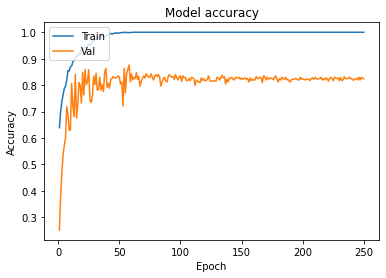

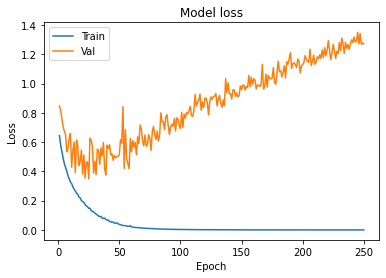

In [233]:
# with CNN1 

model_CNN_1_under = CNN_1()

model_CNN_1_under.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS = 250
BATCH_SIZE = 32

history = model_CNN_1_under.fit(
    x_under_ss, y_train_vec_under, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=2
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.825


<AxesSubplot:>

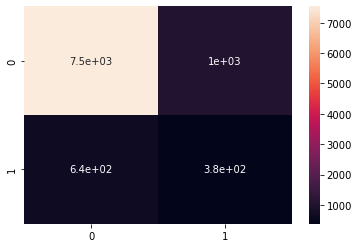

In [234]:
y_pred_vec_CNN_1_under = model_CNN_1_under.predict(x_devel_ss_scaled)

y_pred_CNN_1_under = np.argmax(y_pred_vec_CNN_1_under, axis=1)


acc_CNN_1_under = accuracy_score(y_devel, y_pred_CNN_1_under)

print( "Classification accuracy is:  " + str(round(acc_CNN_1_under,3)))

cm_CNN_1_under = confusion_matrix(y_devel, y_pred_CNN_1_under)
sns.heatmap(cm_CNN_1_under, annot=True)

In [235]:
classification_report_CNN_1_under = classification_report(y_devel, y_pred_CNN_1_under)
print(classification_report_CNN_1_under)

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      8585
           1       0.26      0.37      0.31      1011

    accuracy                           0.83      9596
   macro avg       0.59      0.63      0.60      9596
weighted avg       0.85      0.83      0.84      9596



Random Oversampling

In [236]:
Counter(y_train)

Counter({1: 970, 0: 8535})

In [237]:
x_over_ss, y_over_ss = oversample.fit_resample(x_train_ss_scaled, y_train)

In [238]:
Counter(y_over_ss)

Counter({1: 8535, 0: 8535})

In [239]:
y_train_vec_over = to_categorical(y_over_ss, 2)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 64)                5696      
                                                                 
 dense_68 (Dense)            (None, 32)                2080      
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_69 (Dense)            (None, 16)                528       
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_70 (Dense)            (None, 2)                 34        
                                                                 
Total params: 8,338
Trainable params: 8,338
Non-train

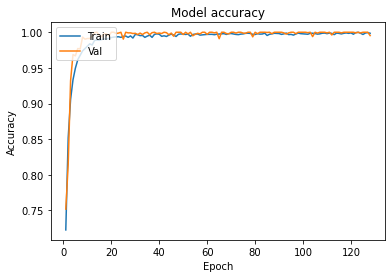

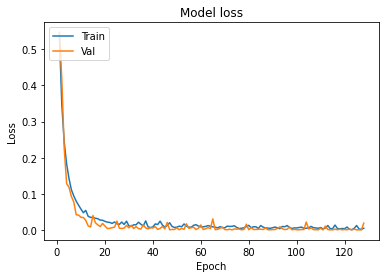

In [242]:
# with model FF2

model_FF_2_over = FF_2()

model_FF_2_over.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS = 128
BATCH_SIZE = 64

history = model_FF_2_over.fit(
    x_over_ss, y_train_vec_over, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=0
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.873


<AxesSubplot:>

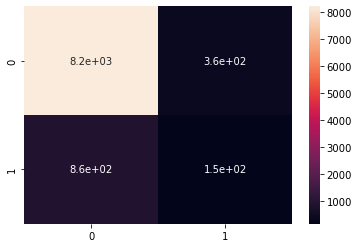

In [243]:
y_pred_vec_model_FF_2_over = model_FF_2_over.predict(x_devel_ss_scaled)

y_pred_model_FF_2_over = np.argmax(y_pred_vec_model_FF_2_over, axis=1)


acc_model_FF_2_over = accuracy_score(y_devel, y_pred_model_FF_2_over)

print( "Classification accuracy is:  " + str(round(acc_model_FF_2_over,3)))

cm_model_FF_2_over = confusion_matrix(y_devel, y_pred_model_FF_2_over)
sns.heatmap(cm_model_FF_2_over, annot=True)

In [244]:
classification_report_model_FF_2_over = classification_report(y_devel, y_pred_model_FF_2_over)
print(classification_report_model_FF_2_over)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      8585
           1       0.30      0.15      0.20      1011

    accuracy                           0.87      9596
   macro avg       0.60      0.55      0.57      9596
weighted avg       0.84      0.87      0.85      9596



Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 64)                5696      
                                                                 
 dense_72 (Dense)            (None, 32)                2080      
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_73 (Dense)            (None, 2)                 66        
                                                                 
Total params: 7,842
Trainable params: 7,842
Non-trainable params: 0
_________________________________________________________________
None


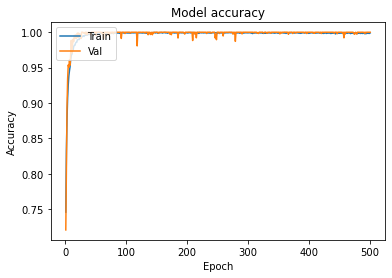

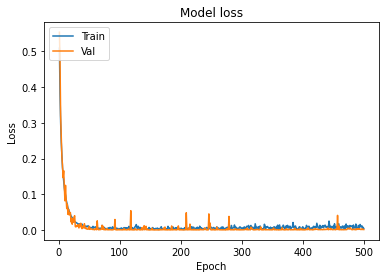

In [245]:
# with model FF3

model_FF_3_over = FF_3()

model_FF_3_over.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS = 500
BATCH_SIZE = 128

history = model_FF_3_over.fit(
    x_over_ss, y_train_vec_over, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=0
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.857


<AxesSubplot:>

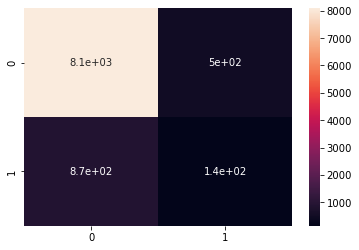

In [246]:
y_pred_vec_model_FF_3_over = model_FF_3_over.predict(x_devel_ss_scaled)

y_pred_model_FF_3_over = np.argmax(y_pred_vec_model_FF_3_over, axis=1)


acc_model_FF_3_over = accuracy_score(y_devel, y_pred_model_FF_3_over)

print( "Classification accuracy is:  " + str(round(acc_model_FF_3_over,3)))

cm_model_FF_3_over = confusion_matrix(y_devel, y_pred_model_FF_3_over)
sns.heatmap(cm_model_FF_3_over, annot=True)

In [247]:
classification_report_model_FF_3_over = classification_report(y_devel, y_pred_model_FF_3_over)
print(classification_report_model_FF_3_over)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      8585
           1       0.22      0.14      0.17      1011

    accuracy                           0.86      9596
   macro avg       0.56      0.54      0.55      9596
weighted avg       0.83      0.86      0.84      9596



Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_17 (Reshape)        (None, 44, 2)             0         
                                                                 
 conv1d_30 (Conv1D)          (None, 42, 32)            224       
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 21, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 19, 64)            6208      
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 9, 64)            0         
 g1D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 576)             

Epoch 56/250
427/427 - 2s - loss: 0.0038 - accuracy: 0.9998 - val_loss: 0.0021 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 57/250
427/427 - 1s - loss: 0.0079 - accuracy: 0.9989 - val_loss: 0.0177 - val_accuracy: 0.9971 - 1s/epoch - 3ms/step
Epoch 58/250
427/427 - 1s - loss: 0.0055 - accuracy: 0.9999 - val_loss: 0.0020 - val_accuracy: 1.0000 - 1s/epoch - 3ms/step
Epoch 59/250
427/427 - 2s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 60/250
427/427 - 2s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 61/250
427/427 - 2s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 62/250
427/427 - 1s - loss: 9.3854e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000 - 1s/epoch - 3ms/step
Epoch 63/250
427/427 - 1s - loss: 8.8393e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 - 1s/epoch - 3ms/step


Epoch 120/250
427/427 - 2s - loss: 1.5686e-04 - accuracy: 1.0000 - val_loss: 2.3312e-04 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 121/250
427/427 - 2s - loss: 1.4044e-04 - accuracy: 1.0000 - val_loss: 2.2982e-04 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 122/250
427/427 - 2s - loss: 1.2600e-04 - accuracy: 1.0000 - val_loss: 2.8720e-04 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 123/250
427/427 - 2s - loss: 1.1494e-04 - accuracy: 1.0000 - val_loss: 1.7040e-04 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 124/250
427/427 - 2s - loss: 1.0464e-04 - accuracy: 1.0000 - val_loss: 1.5299e-04 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 125/250
427/427 - 1s - loss: 9.5225e-05 - accuracy: 1.0000 - val_loss: 1.7040e-04 - val_accuracy: 1.0000 - 1s/epoch - 3ms/step
Epoch 126/250
427/427 - 2s - loss: 8.6029e-05 - accuracy: 1.0000 - val_loss: 1.3603e-04 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 127/250
427/427 - 2s - loss: 7.7144e-05 - accuracy: 1.0000 - va

Epoch 182/250
427/427 - 2s - loss: 1.4132e-05 - accuracy: 1.0000 - val_loss: 1.9932e-05 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 183/250
427/427 - 1s - loss: 1.3081e-05 - accuracy: 1.0000 - val_loss: 2.8248e-04 - val_accuracy: 1.0000 - 1s/epoch - 3ms/step
Epoch 184/250
427/427 - 2s - loss: 0.0861 - accuracy: 0.9851 - val_loss: 0.0857 - val_accuracy: 0.9930 - 2s/epoch - 4ms/step
Epoch 185/250
427/427 - 2s - loss: 0.0149 - accuracy: 0.9982 - val_loss: 0.0019 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 186/250
427/427 - 2s - loss: 4.7716e-04 - accuracy: 0.9999 - val_loss: 8.2717e-04 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 187/250
427/427 - 2s - loss: 1.5464e-04 - accuracy: 1.0000 - val_loss: 2.2457e-04 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 188/250
427/427 - 2s - loss: 1.0867e-04 - accuracy: 1.0000 - val_loss: 2.3982e-04 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 189/250
427/427 - 2s - loss: 9.4316e-05 - accuracy: 1.0000 - val_loss: 1.4413e-

Epoch 244/250
427/427 - 1s - loss: 4.6918e-06 - accuracy: 1.0000 - val_loss: 1.0614e-05 - val_accuracy: 1.0000 - 1s/epoch - 3ms/step
Epoch 245/250
427/427 - 1s - loss: 4.1482e-06 - accuracy: 1.0000 - val_loss: 4.6519e-06 - val_accuracy: 1.0000 - 1s/epoch - 3ms/step
Epoch 246/250
427/427 - 2s - loss: 3.7477e-06 - accuracy: 1.0000 - val_loss: 6.5196e-06 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 247/250
427/427 - 1s - loss: 3.2774e-06 - accuracy: 1.0000 - val_loss: 5.7040e-06 - val_accuracy: 1.0000 - 1s/epoch - 3ms/step
Epoch 248/250
427/427 - 2s - loss: 3.0152e-06 - accuracy: 1.0000 - val_loss: 5.1093e-06 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step
Epoch 249/250
427/427 - 1s - loss: 2.7561e-06 - accuracy: 1.0000 - val_loss: 4.6122e-06 - val_accuracy: 1.0000 - 1s/epoch - 3ms/step
Epoch 250/250
427/427 - 2s - loss: 2.3348e-06 - accuracy: 1.0000 - val_loss: 3.7319e-06 - val_accuracy: 1.0000 - 2s/epoch - 4ms/step


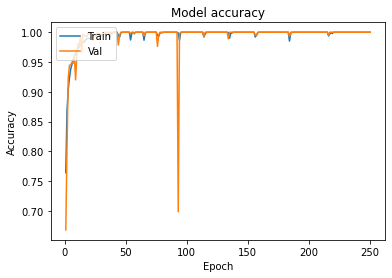

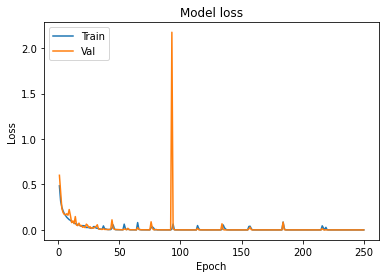

In [248]:
# with CNN1

model_CNN_1_over = CNN_1()

model_CNN_1_over.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS = 250
BATCH_SIZE = 32

history = model_CNN_1_over.fit(
    x_over_ss, y_train_vec_over, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_split = 0.2,
    shuffle=True,
    verbose=2
)
plot_learningCurve(history, EPOCHS)

Classification accuracy is:  0.878


<AxesSubplot:>

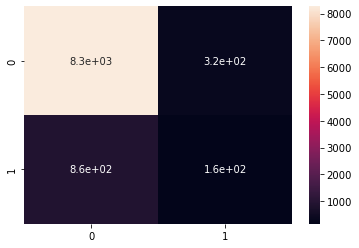

In [249]:
y_pred_vec_CNN_1_over = model_CNN_1_over.predict(x_devel_ss_scaled)

y_pred_CNN_1_over = np.argmax(y_pred_vec_CNN_1_over, axis=1)


acc_CNN_1_over = accuracy_score(y_devel, y_pred_CNN_1_over)

print( "Classification accuracy is:  " + str(round(acc_CNN_1_over,3)))

cm_CNN_1_over = confusion_matrix(y_devel, y_pred_CNN_1_over)
sns.heatmap(cm_CNN_1_over, annot=True)

In [250]:
classification_report_CNN_1_over = classification_report(y_devel, y_pred_CNN_1_over)
print(classification_report_CNN_1_over)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      8585
           1       0.33      0.15      0.21      1011

    accuracy                           0.88      9596
   macro avg       0.62      0.56      0.57      9596
weighted avg       0.85      0.88      0.86      9596

